In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('AAPL.csv')

In [3]:
# Preprocess the data

scaler = MinMaxScaler()
data = scaler.fit_transform(df["close"].values.reshape(-1, 1))
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [4]:
# Define the LSTM model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(None, 1)),
    tf.keras.layers.Dense(1)
])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-10 02:11:49.122081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-10 02:11:49.122527: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Define the GWO optimizer
class GWOOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, population_size=5, max_iter=100, lb=-1, ub=1, **kwargs):
        super(GWOOptimizer, self).__init__(name='GWOOptimizer', **kwargs)
        self.population_size = population_size
        self.max_iter = max_iter
        self.lb = lb
        self.ub = ub

    def build(self, input_shape):
        pass

    def objective_function(self, weights):
        # Set the weights of the LSTM model to the given values
        self.set_weights(weights)
        
        # Train the LSTM model on the training data
        self.model.fit(train_data, epochs=10, batch_size=32, verbose=0)
        
        # Evaluate the performance of the LSTM model on the validation data
        y_pred = self.model.predict(val_data)
        mse = np.mean(np.square(y_pred - val_data))
        
        return mse

    def minimize(self, objective_function):
        population = np.random.uniform(low=self.lb, high=self.ub, size=(self.population_size, self.num_weights))
        
        for t in range(self.max_iter):
            a = 2 - 2 * t / (self.max_iter - 1)
            a2 = -1 + 2 * t / (self.max_iter - 1)
            for i in range(self.population_size):
                r1, r2, r3 = i, np.random.randint(self.population_size), np.random.randint(self.population_size)
                A1, A2, A3 = population[r1], population[r2], population[r3]
                C1, C2, C3 = 2 * np.random.rand(self.num_weights) - 1, 2 * np.random.rand(self.num_weights) - 1, 2 * np.random.rand(self.num_weights) - 1
                D_alpha, D_beta, D_delta = np.abs(C1 * A1 - population[i]), np.abs(C2 * A2 - population[i]), np.abs(C3 * A3 - population[i])
                X1, X2, X3 = A1 - a * D_alpha, A2 - a * D_beta, A3 - a * D_delta
                new_position = (X1 + X2 + X3) / 3
                for j in range(self.num_weights):
                    if new_position[j] < self.lb:
                        new_position[j] = (A1[j] + A2[j] + A3[j]) / 3
                    if new_position[j] > self.ub:
                        new_position[j] = (A1[j] + A2[j] + A3[j]) / 3
                mse = objective_function(population[i])
                if mse > objective_function(new_position):
                    population[i] = new_position
                else:
                    r = np.random.rand()
                    if r < a2:
                        population[i] = new_position
        
        best_position = population[np.argmin([objective_function(p) for p in population])]
        self.set_weights(best_position)

    def get_config(self):
        config = super(GWOOptimizer, self).get_config()
        config.update({
            "population_size": self.population_size,
            "max_iter": self.max_iter,
            "lb": self.lb,
            "ub": self.ub
        })
        return config

In [6]:
# Define the objective function
def objective_function(params):
    # Set the LSTM model weights
    model.set_weights(params)
    
    # Train the LSTM model with the GWO optimizer
    optimizer = GWOOptimizer()
    model.compile(optimizer=optimizer, loss="mse")
    model.fit(train_data, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate the performance of the LSTM model on the test data
    y_pred = model.predict(test_data)
    mse = np.mean(np.square(y_pred - test_data))
    return mse

In [8]:
optimizer = GWOOptimizer()
model.compile(optimizer=optimizer, loss="mse")
model.fit(train_data, epochs=10, batch_size=32)
model.fit(x=train_data, y=target_data, epochs=10, batch_size=32)

Epoch 1/10


2023-04-10 02:12:10.433783: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/anubhavbehera/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/anubhavbehera/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/anubhavbehera/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/anubhavbehera/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 891, in train_step
        self._validate_target_and_loss(y, loss)
    File "/Users/anubhavbehera/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 848, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=mse, and therefore expects target data to be provided in `fit()`.


In [9]:
y_pred = model.predict(test_data)
mse = np.mean(np.square(y_pred - test_data))
print("MSE: ", mse)

2023-04-10 02:12:13.520404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-10 02:12:13.574179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 7ms/step
MSE:  0.491503122735346


In [10]:
y_pred = scaler.inverse_transform(y_pred)

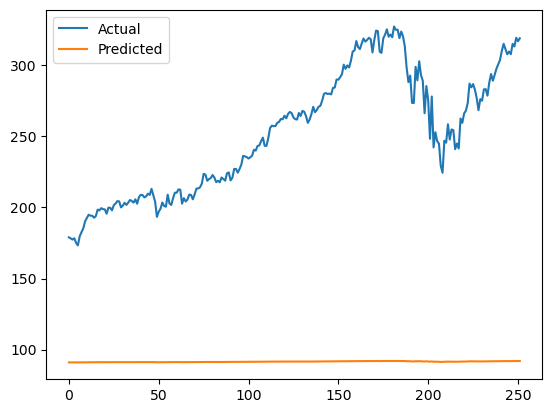

In [11]:
import matplotlib.pyplot as plt
plt.plot(df["close"].values[train_size:], label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.show()